In [81]:
from datetime import date
import json 
import shutil
from datasets import load_dataset, load_metric, Dataset
from torch.utils.data import DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

dataset_name = "cais/mmlu"  # The MMLU dataset name in Hugging Face Datasets
mmlu_subjects = ['abstract_algebra', 'anatomy', 'astronomy', 'business_ethics', 'clinical_knowledge', 'college_biology', 'college_chemistry', 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics', 'computer_security', 'conceptual_physics', 'econometrics', 'electrical_engineering', 'elementary_mathematics', 'formal_logic', 'global_facts', 'high_school_biology', 'high_school_chemistry', 'high_school_computer_science', 'high_school_european_history', 'high_school_geography', 'high_school_government_and_politics', 'high_school_macroeconomics', 'high_school_mathematics', 'high_school_microeconomics', 'high_school_physics', 'high_school_psychology', 'high_school_statistics', 'high_school_us_history', 'high_school_world_history', 'human_aging', 'human_sexuality', 'international_law', 'jurisprudence', 'logical_fallacies', 'machine_learning', 'management', 'marketing', 'medical_genetics', 'miscellaneous', 'moral_disputes', 'moral_scenarios', 'nutrition', 'philosophy', 'prehistory', 'professional_accounting', 'professional_law', 'professional_medicine', 'professional_psychology', 'public_relations', 'security_studies', 'sociology', 'us_foreign_policy', 'virology', 'world_religions']
split = "test"
mmlu_dataset = load_dataset(dataset_name,"all")[split]



In [110]:
main_dir = "/home/ubuntu/data/iMMLU/"
model_name = main_dir+ "Mistral-7B-tuned-4bit/"
num_layers = 32
num_shots = 5

acc_mean2 = []
acc_mean = []
F1_A_mean =[]
F1_B_mean =[]
F1_C_mean =[]
F1_D_mean =[]

# mistral
layer_list = np.arange(15,31,1)
# llama2-13b
# layer_list = np.arange(19,39,1)
# llama2-70b
# layer_list = np.arange(55,79,1)
for layers in layer_list:
    layer_dir = model_name + f"layers_removed_{layers}/"

    acc_subj = []
    acc_subj2 = []
    F1_A = []
    F1_B = []
    F1_C = []
    F1_D = []
    for subject in mmlu_subjects:
    # for subject in mmlu_subjects[:10]:
        # Prepare variables to collect MMLU data
        answers = []
        
        true_choice = torch.tensor(mmlu_dataset.filter(lambda example: example["subject"]==subject)["answer"][:])
        id_A = torch.argwhere((true_choice)==0)[:,0]
        id_B = torch.argwhere((true_choice)==1)[:,0]
        id_C = torch.argwhere((true_choice)==2)[:,0]
        id_D = torch.argwhere((true_choice)==3)[:,0]
        
        file_dir =  layer_dir+f"subject_{subject}_shots_{num_shots}/"

        fname = file_dir+ "accuracy.json"
        if not os.path.exists(fname):
            continue
        with open(fname, 'r') as log_file:
            # Read the log file line by line
            for line in log_file:
                acc_subj2.append(json.loads(line))


        fname = file_dir+ "accuracy_per_question.json"
        with open(fname, 'r') as log_file:
            # Read the log file line by line
            for line in log_file:
                acc_list = np.array(json.loads(line))

        fname = file_dir+ "model_answers.json"
        with open(fname, 'r') as log_file:
            # Read the log file line by line
            for line in log_file:
                ans_list = np.array(json.loads(line))

        acc = np.sum(acc_list)
        acc_calc = np.argwhere(ans_list==true_choice.numpy()).shape[0]
        assert acc== acc_calc
        acc_subj.append(acc/acc_list.shape[0])

        true_answers = np.argwhere(acc_list==1)[:,0]
        true_A = np.intersect1d(id_A,true_answers).shape[0]
        true_B = np.intersect1d(id_B,true_answers).shape[0]
        true_C = np.intersect1d(id_C,true_answers).shape[0]
        true_D = np.intersect1d(id_D,true_answers).shape[0]
        assert acc== (true_A+true_B+true_C+ true_D)

        A_chosen = np.argwhere(ans_list==0).shape[0]
        B_chosen = np.argwhere(ans_list==1).shape[0]
        C_chosen = np.argwhere(ans_list==2).shape[0]
        D_chosen = np.argwhere(ans_list==3).shape[0]
        
        F1_A.append(2*true_A/(A_chosen+id_A.shape[0]))
        F1_B.append(2*true_B/(B_chosen+id_B.shape[0]))
        F1_C.append(2*true_C/(C_chosen+id_C.shape[0]))
        F1_D.append(2*true_D/(D_chosen+id_D.shape[0]))

    if len(acc_subj)>0:
        acc_mean2.append(np.array(acc_subj2).mean())
        acc_mean.append(np.array(acc_subj).mean())
        F1_A_mean.append(np.array(F1_A).mean())
        F1_B_mean.append(np.array(F1_B).mean())
        F1_C_mean.append(np.array(F1_C).mean())
        F1_D_mean.append(np.array(F1_D).mean())
    

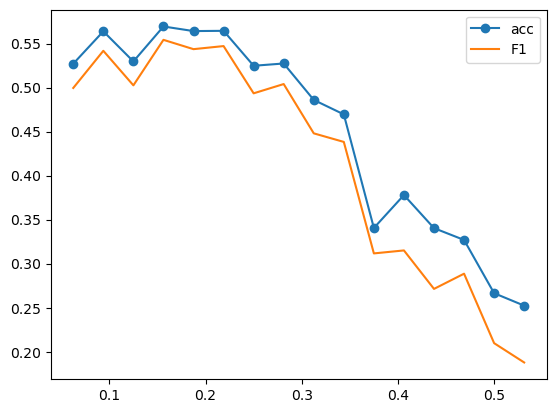

In [113]:
plt.plot(1-layer_list/num_layers,acc_mean,"o-",label = "acc")
# plt.plot(40-layer_list,acc_mean2)
F1_mean = np.array([F1_A_mean,F1_B_mean,F1_C_mean,F1_D_mean]).mean(axis=0)
plt.plot(1-layer_list/num_layers,F1_mean,label = "F1")
# plt.plot(1-layer_list/num_layers,F1_A_mean,label = "F1_A")
# plt.plot(1-layer_list/num_layers,F1_B_mean,label = "F1_B")
# plt.plot(1-layer_list/num_layers,F1_C_mean,label = "F1_C")
# plt.plot(1-layer_list/num_layers,F1_D_mean,label = "F1_D")
plt.legend()
plt.show()
# print(correct,correct_calc)
# print((ans_list))
# print(true_choice.numpy())

In [50]:
print(true_A+true_B+true_C+ true_D)

27
